In [670]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Digraph
import os
from IPython import display
import logging

In [715]:
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.ERROR, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

In [672]:
# Required for Jupyter Notebook to find the graphviz executables
os.environ["PATH"] += os.pathsep + os.path.abspath("/opt/homebrew/bin/")

In [673]:
# Sample function for gradient calculation
def f(x):
    return 3*x**2 - 4*x + 5

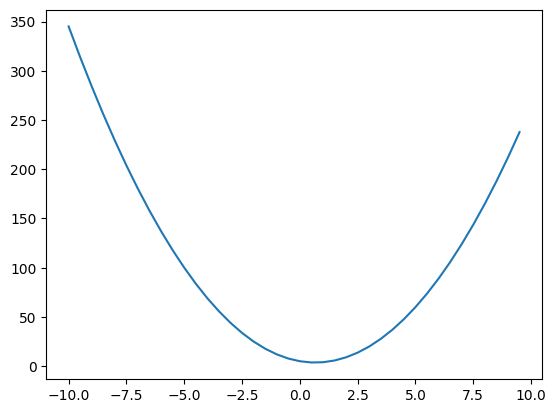

In [674]:
xs = np.arange(-10, 10, 0.5)
ys = f(xs)
plt.plot(xs, ys)
plt.show()

In [675]:
h = 0.000001

In [676]:
a = 3
b = -2
c = 1
d1 = a*b + c

In [677]:
c = c + h
d2 = a*b + c

In [678]:
print("d1 = ", d1)
print("d2 = ", d2)
print("dc_dy = ", (d2 - d1) / h)

d1 =  -5
d2 =  -4.999999
dc_dy =  1.000000000139778


In [679]:
a = 3; b = -2; c = 1
d1 = a*b + c
a = a + h
d2 = a*b + c
print("d1 = ", d1)
print("d2 = ", d2)
print("da_dy = ", (d2 - d1) / h)

d1 =  -5
d2 =  -5.000002
da_dy =  -2.000000000279556


In [680]:
a = 3; b = -2; c = 1
d1 = a*b + c
b = b + h
d2 = a*b + c
print("d1 = ", d1)
print("d2 = ", d2)
print("db_dy = ", (d2 - d1) / h)

d1 =  -5
d2 =  -4.9999970000000005
db_dy =  2.9999999995311555


In [681]:
a = 3; b = -2; c = 1
d1 = a*b + c
d2 = a*b + h + c
print("d1 = ", d1)
print("d2 = ", d2)
print("dab_dy = ", (d2 - d1) / h)

d1 =  -5
d2 =  -4.999999
dab_dy =  1.000000000139778


In [682]:
class Value():
    """ Basic class to represent a scale value with arithmeti operations and gradients. """
    def __init__(self, data, _children=(), _op = '', grad=0.0, label=""):
        self.data = data
        self._prev = _children
        self._op = _op
        self.label = label
        self.grad = 0.0  # Gradient initialized to zero
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        if isinstance(other, Value):
            return Value(self.data + other.data, _children=(self, other), _op='+')
        else:
            raise ValueError("Can only add Value to Value")
    
    def __mul__(self, other):
        if isinstance(other, Value):
            return Value(self.data * other.data, _children=(self, other), _op='*')
        else:
            raise ValueError("Can only multiply Value to Value")
        
    def tanh(self):
        return Value((np.exp(self.data*2) - 1)/(np.exp(self.data*2) + 1), _op='tanh', _children=(self,))

In [683]:
a = Value(3, label="a")
b = Value(-2, label="b")
c = Value(1, label="c")
d = a*b + c; d.label = "d"
print(f"d._prev = {d._prev} d = {d.data}")

d._prev = (Value(data=-6), Value(data=1)) d = -5


In [684]:
def draw_graph(root):
    """ Vibe codded and it works! """
    # Initialize a directed graph
    dot = Digraph(format='png', graph_attr={'rankdir': 'LR'})  # Left-to-right layout
    
    def build_graph(node, visited=None):
        if visited is None:
            visited = set()
        
        # Skip if node already visited to avoid cycles
        if id(node) in visited:
            return
        visited.add(id(node))
        
        # Add node to the graph
        node_id = str(id(node))
        dot.node(node_id, f"{{ {node.label} | data = {node.data} grad={node.grad} }}", shape='record')
        
        # If node has an operation, create an operation node
        if node._op:
            op_id = f"{node_id}_op"
            dot.node(op_id, node._op, shape='circle')
            dot.edge(op_id, node_id)  # Edge from operation to result
        
            # Recursively process children
            for child in node._prev:
                child_id = str(id(child))
                build_graph(child, visited)
                dot.edge(child_id, op_id)  # Edge from child to operation
    
    # Build the graph starting from the root
    build_graph(root)
    
    # Render and display the graph
    dot.render('computation_graph', view=True, cleanup=True)
    
    return dot


In [685]:
# draw_graph(d)

In [686]:
# Forward pass for neural network with one neuron
# Inputs: x1, x2; Weights: w1, w2; Bias: b; Output: y

x1 = Value(2, label="x1")
x2 = Value(3, label="x2")
w1 = Value(0.5, label="w1")
w2 = Value(-1.5, label="w2")
b = Value(1, label="b")
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = "x1w1_x2w2"
y = x1w1_x2w2 + b; y.label = "y"
o = y.tanh(); o.label = "o"

In [687]:
print(f"o = {o.data}")

o = -0.9866142981514304


In [688]:
# draw_graph(o)

In [689]:
# Backpropagation
o.grad = 1.0  # Set the gradient of the output to 1.0

In [690]:
# draw_graph(o)

In [691]:
do_dn = 1 - math.tanh(o.data)**2
y.grad = do_dn

In [692]:
# draw_graph(o)

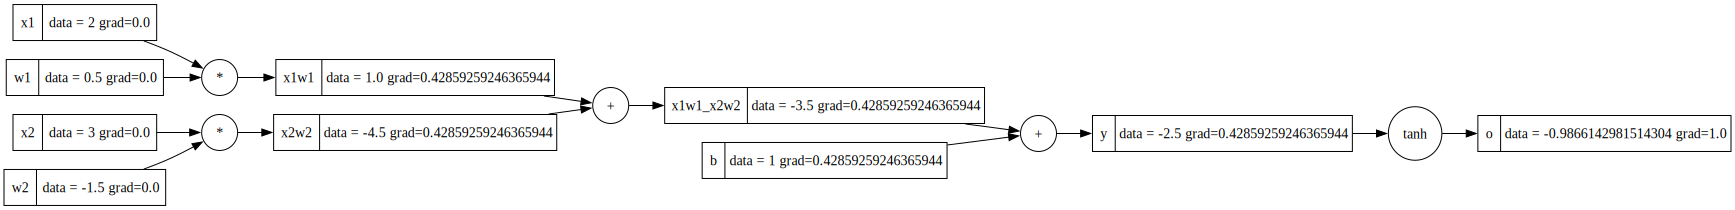

In [ ]:
x1w1_x2w2.grad = y.grad
b.grad = y.grad
x1w1.grad = x1w1_x2w2.grad
x2w2.grad = x1w1_x2w2.grad

# draw_graph(o)

In [694]:
x1.grad = x1w1.grad * w1.data
x2.grad = x2w2.grad * w2.data
w1.grad = x1w1.grad * x1.data
w2.grad = x2w2.grad * x2.data

# draw_graph(o)

In [716]:
# Implement generic backpropagation
class Value():
    """ Complete class with backprop to represent a scale value with arithmeti operations and gradients. """
    def __init__(self, data, _children=(), _op = '', grad=0.0, label=""):
        self.data = data
        self._prev = _children
        self._op = _op
        self.label = label
        self.grad = 0.0  # Gradient initialized to zero
        self.label = ""

    def backward(self, root_node, visited=None):
        visited.add(self)
        logger.debug(f"node.data = {self.data}")
        self._backward()  # Compute the gradient for childeren of this node
        for item in self._prev:
            if item not in visited:
                item.backward(root_node, visited)

    def _backward(self):
        """ Perform backpropagation to compute gradients. """
        logger.debug(f"Backward pass for node: {self.label}, op: {self._op}, data: {self.data}, grad: {self.grad}")
        # For addition operation, local gradient is 1 for each child hence gradient of the child with respect
        # to the output is 1 * self gradient.
        # Note, we need to accumulate gradients for each child and not simply overwrite them.
        if self._op == '+':
            for child in self._prev:
                child.grad += self.grad

        # For multiplication operation, local gradient is the value of the other child hence
        # gradient of the child with respect to the output is self.grad * other child's value.
        elif self._op == '*':
            self._prev[0].grad = self.grad * self._prev[1].data
            self._prev[1].grad = self.grad * self._prev[0].data

        elif self._op == '/':
            # For division operation, local gradient is 1 / other child's value hence
            # gradient of the child with respect to the output is self.grad * (1 / other child's value).
            self._prev[0].grad = self.grad / self._prev[1].data
            self._prev[1].grad = -self.grad * (self._prev[0].data / (self._prev[1].data ** 2))

        # For power operation, local gradient is power * base^(power-1) hence
        # gradient of the child with respect to the output is self.grad * local gradient.
        elif self._op == '**':
            power = self._prev[0].data
            base = self.data
            self._prev[0].grad = self.grad * power * (base ** (power - 1))

        # For subtraction operation, local gradient is 1 for the first child and -1 for the second child
        # hence gradient of the first child with respect to the output is self.grad * 1 and for the second child
        # it is self.grad * -1.
        elif self._op == '-':
            self._prev[0].grad = self.grad  # First child
            self._prev[1].grad = -self.grad  # Second child

        # For tanh operation, local gradient is 1 - tanh^2(self.data) hence
        # gradient of the child with respect to the output is self.grad * local gradient.
        elif self._op == 'tanh':
            logger.debug(f"tanh: self.data = {self.data}, self.grad = {self.grad}")
            self._prev[0].grad = self.grad * (1 - np.tanh(self._prev[0].data)**2)

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other)  # Convert to Value if not already
        return Value(self.data + other.data, _children=(self, other), _op='+')

    def __radd__(self, other):
        if not isinstance(other, Value):
            other = Value(other)  # Convert to Value if not already
        return Value(self.data + other.data, _children=(self, other), _op='+')
    
    def __sub__(self, other):
        if isinstance(other, Value):
            return Value(self.data - other.data, _children=(self, other), _op='-')
        else:
            raise ValueError("Can only subtract Value from Value")
        
    def __mul__(self, other):
        if isinstance(other, Value):
            return Value(self.data * other.data, _children=(self, other), _op='*')
        else:
            raise ValueError("Can only multiply Value to Value")
        
    def __truediv__(self, other):
        if not isinstance(other, Value):
            other = Value(other)  # Convert to Value if not already
        return Value(self.data / other.data, _children=(self, other), _op='/')

    def __rtruediv__(self, other):
        if not isinstance(other, Value):
            other = Value(other)  # Convert to Value if not already
        return Value(self.data / other.data, _children=(self, other), _op='/')
        
    def __pow__(self, power):
        return Value(self.data ** power, _children=(self,), _op='**')
        
    def tanh(self):
        return Value((np.exp(self.data*2) - 1)/(np.exp(self.data*2) + 1), _op='tanh', _children=(self,))

In [717]:
# Forward pass for neural network with one neuron
# Inputs: x1, x2; Weights: w1, w2; Bias: b; Output: y

x1 = Value(2, label="x1")
x2 = Value(3, label="x2")
w1 = Value(0.5, label="w1")
w2 = Value(-1.5, label="w2")
b = Value(1, label="b")
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = "x1w1_x2w2"
y = x1w1_x2w2 + b; y.label = "y"
o = y.tanh(); o.label = "o"

In [718]:
# draw_graph(o)

In [719]:
# Perform backpropagation
o.grad = 1.0  # Set the gradient of the output to 1.0

visited = set()
o.backward(o, visited)

In [720]:
# draw_graph(o)

In [721]:
# Verfiy with PyTorch
# Forward pass for neural network with one neuron
# Inputs: x1, x2; Weights: w1, w2; Bias: b; Output: y

import torch

x1 = torch.Tensor([2.0])
x2 = torch.Tensor([3.0])
w1 = torch.Tensor([0.5])
w2 = torch.Tensor([-1.5])
b = torch.Tensor([1.0])
x1.requires_grad = True
x2.requires_grad = True
w1.requires_grad = True
w2.requires_grad = True
b.requires_grad = True

y = x1 * w1 + x2 * w2 + b
o = torch.tanh(y)

print(f"o = {o.item()}")

o.backward()  # Perform backpropagation

o = -0.9866142868995667


In [722]:
print(f"x1.grad = {x1.grad.item()}") 
print(f"x2.grad = {x2.grad.item()}") 
print(f"w1.grad = {w1.grad.item()}")
print(f"w2.grad = {w2.grad.item()}")
print(f"b.grad = {b.grad.item()}")

x1.grad = 0.013296124525368214
x2.grad = -0.039888374507427216
w1.grad = 0.053184498101472855
w2.grad = 0.07977674901485443
b.grad = 0.026592249050736427


In [723]:
import random

class N():
    """ Class to represent a single neuron with forward and backward pass. """
    def __init__(self, input_size):
        self.input_size = input_size
        self.weights = [Value(random.uniform(-1, 1)) for _ in range(input_size)]
        self.b = Value(random.uniform(-1, 1))  # Bias term
    
    def parameters(self):
        return self.weights + [self.b]  # Return all parameters (weights and bias)
    
    def __call__(self, input) -> Value:
        """ Forward pass for the neuron. """
        wx = [w*x for w, x in zip(self.weights, input)]
        wx_sum = Value(0.0)  # Initialize sum of weighted inputs
        for item in wx:
            wx_sum += item  # Sum the weighted inputs

        wx_sum = wx_sum + self.b
        return wx_sum.tanh()
        

In [724]:
n = N(2)  # Create a neuron with 2 inputs
x1 = Value(2, label="x1")
x2 = Value(3, label="x2")

o = n([x1, x2])
print(f"o = {o.data}")

o = 0.9990284685477849


In [725]:
class Layer():
    """ Class to represent a layer of neurons. """
    def __init__(self, layer_size, input_size):
        self.layer_size = layer_size
        self.neurons = [N(input_size) for _ in range(layer_size)]
    
    def parameters(self):
        parameters = []
        for n in self.neurons:
            parameters.extend(n.parameters())  # Collect parameters from each neuron
        return parameters
            
    def __call__(self, input):
        """ Forward pass for the layer. """
        outputs = [n(input) for n in self.neurons]
        return outputs

In [726]:
class NN():
    """ Class to represent a simple neural network with hidden layers. """
    def __init__(self, input_size: int, 
                 hidden_layer_num: int, 
                 hidden_layer_size: int, 
                 output_size: int):
        self.input_size = input_size
        self.hidden_layer_num = hidden_layer_num
        self.output_size = output_size
        self.hidden_layer_size = hidden_layer_size

        self.layers = []
        for i in range(hidden_layer_num):
            if i == hidden_layer_num - 1:
                # Last layer is the output layer, use output_size
                self.layers.append(Layer(output_size, input_size))
            else:
                self.layers.append(Layer(hidden_layer_size, input_size))

    def parameters(self):
        parameters = []
        for layer in self.layers:
            parameters.extend(layer.parameters())  # Collect parameters from each layer
        return parameters

    def __call__(self, input):
        """ Forward pass for the neural network. """
        assert len(input) == self.input_size, "input size mismatch"
        input = [Value(x) for x in input]
        
        layer_output = None
        for i, layer in enumerate(self.layers):
            if i == 0:
                # First layer takes the input directly
                layer_output = layer(input)
            else:
                # Subsequent layers take the output of the previous layer
                layer_output = layer(layer_output)

        return layer_output

In [727]:
nn = NN(input_size=3, hidden_layer_num=2, hidden_layer_size=3, output_size=1)  # Create a neural network with 2 inputs, 2 hidden layers of size 3, and 1 output 

In [728]:
print("model information:")
print(f"total model layers: {len(nn.layers)}")
for i, layer in enumerate(nn.layers):
    print(f"[{i}] layer size: {layer.layer_size}, input size: {layer.neurons[0].input_size}, neurons: {len(layer.neurons)}")
print(f"total model parameters: {len(nn.parameters())}")

model information:
total model layers: 2
[0] layer size: 3, input size: 3, neurons: 3
[1] layer size: 1, input size: 3, neurons: 1
total model parameters: 16


In [729]:
input = [1.0, 2.0, 3.0]  # Example input
output = nn(input)  # Forward pass through the neural network

print(f"Output of the neural network: {[o.data for o in output]}")

Output of the neural network: [0.1080010283530053]


In [730]:
x = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

y = [1.0, -1.0, -1.0, 1.0]  # Example labels

In [731]:
y_preds = [nn(i)[0] for i in x]

In [732]:
print(f"Predictions: {[item.data for item in y_preds]}")

Predictions: [0.06712271803217608, 0.8966946660706241, 0.447304595139257, 0.6329504609226184]


In [733]:
def loss_fn(y_preds, y_true):
    """Mean squared error loss function."""
    loss = [(i**2 - j**2) for i, j in zip(y_preds, y_true)]
    loss = sum(loss)

    return loss / len(y_preds)

In [734]:
y_true = [Value(i) for i in y]  # Convert labels to Value objects
print(f"y_preds = {[i.data for i in y_preds]}")
print(f"y_true = {[i.data for i in y_true]}")
loss = loss_fn(y_preds, y_true)
print(f"Loss: {loss.data}")

y_preds = [0.06712271803217608, 0.8966946660706241, 0.447304595139257, 0.6329504609226184]
y_true = [1.0, -1.0, -1.0, 1.0]
Loss: -0.6476813824374038


In [735]:
loss.grad = 1.0  # Set the gradient of the loss to 1.0
visited = set()
loss.backward(loss, visited)

In [736]:
# draw_graph(loss)

In [737]:
for param in nn.parameters():
    param.data = param.data - 0.001 * param.grad  # Update parameters using gradient descent

In [738]:
y_preds = [nn(i)[0] for i in x]

In [739]:
loss = loss_fn(y_preds, y_true)
print(f"Loss: {loss.data}")

Loss: -0.649468019685703


In [740]:
# Run model training for multiple epochs
epochs = 10
learning_rate = 0.001

for epoch in range(epochs):
    y_preds = [nn(i)[0] for i in x]  # Forward pass through the neural network
    loss = loss_fn(y_preds, y_true)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.data}")
    
    loss.grad = 1.0  # Set the gradient of the loss to 1.0
    visited = set()
    loss.backward(loss, visited)
    for param in nn.parameters():
        param.data = param.data - learning_rate * param.grad  # Update parameters using gradient descent

Epoch 1/10, Loss: -0.649468019685703
Epoch 2/10, Loss: -0.6529756438263243
Epoch 3/10, Loss: -0.6583737149158561
Epoch 4/10, Loss: -0.6660238302446786
Epoch 5/10, Loss: -0.6768674571172512
Epoch 6/10, Loss: -0.6967283565171443
Epoch 7/10, Loss: -0.7111270154702596
Epoch 8/10, Loss: -0.7226997228877843
Epoch 9/10, Loss: -0.7323155827689879
Epoch 10/10, Loss: -0.7404522681975103


In [647]:
print(f"y_preds after training: {[item.data for item in y_preds]}")
print(f"y_true after training: {[item.data for item in y_true]}")

y_preds after training: [0.9606345709131762, 0.9737648203903666, 0.8310004943519919, 0.9546225261915703]
y_true after training: [1.0, -1.0, -1.0, 1.0]
